# Character-level Language Modeling with LSTMs

**Goals**
* Download a small text corpus and preprocess it.
* Extract a character vocabulary and use it to vectorize the text.
* Train a LSTM-based character level language model.
* Use the trained model to sample random text with varying entropy levels.
* Implement a beam-serach deterministic decoder.

**Dataset**
* Eminem lyrics from [Kaggle](https://www.kaggle.com/paultimothymooney/poetry).

In [ ]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter

from nltk.corpus import gutenberg
from nltk.tokenize import sent_tokenize

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

from sklearn.utils import shuffle

## Loading some text data

We will use the lyrics from the different Eminem songs.

In [ ]:
CORPUS_PATH = 'eminem.txt'
text = open(CORPUS_PATH).read().lower()
print(f'The corpus contains {len(text)} characters.')

The corpus contains 322578 characters.


In [ ]:
# Print the beginning of the corpus
print(text[:100], '...')

look, i was gonna go easy on you and not to hurt your feelings
but i'm only going to get this one ch ...


In [ ]:
# Replace '\n' by ' '
text = text.replace('\n', ' ')

In [ ]:
# Split the data into train and test set
split = int(0.9 * len(text))
train_text = text[:split]
test_test = text[split:]

## Building a vocabulary of all possible symbols

To simplify things, we build a vocabulary by extracting the list of all possible characters from the full datasets (train and test). In a more realistic stting, we would need to take into account that the test data can hold symbols never seen in the training set. This issue is limited when we work at the character level though.

Let's build the list of all possible characters and sort it to assign a unique integer to aech possible symbol in the corpus.

In [ ]:
chars = sorted(list(set(text)))
print(f'Total number of characters: {len(chars)}.')

Total number of characters: 60.


In [ ]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

The dictionnary `char_indices` is a mapping from characters to integer identifiers. And the dictionnary `indices_char` holds the reverse mapping.

While not strictly required to build a language model, it is a good idea to have a look at the distribution of relative frequencies of each symbol in the corpus.

In [ ]:
counter = Counter(text)
chars, counts = zip(*counter.most_common())
idx = np.arange(len(counts))

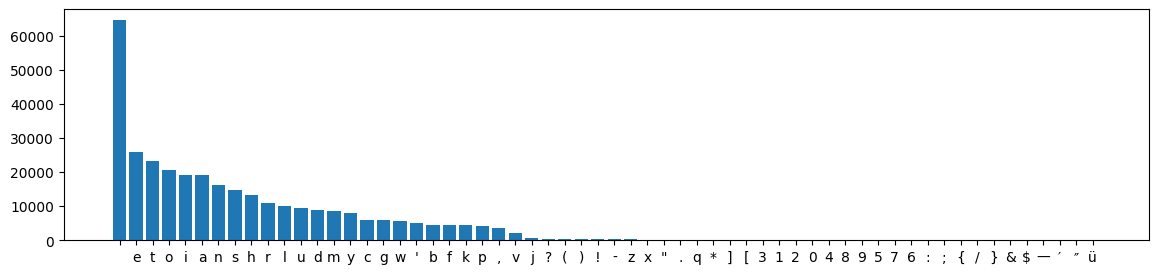

In [ ]:
plt.figure(figsize=(14, 3))
plt.bar(idx, counts, 0.8)
plt.xticks(idx, chars)
plt.show()

Let's cut the dataset into fake sentences at random with some overlap. Instead of cutting at random, we could use a English specific sentence tokenizer.

In [ ]:
def make_sequence(text, max_length=40, step=3):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_length, step):
        sequences.append(text[i:(i + max_length)])
        next_chars.append(text[i + max_length])
    return sequences, next_chars

In [ ]:
MAX_LENGTH = 40
STEP = 3

sequences, next_chars = make_sequence(train_text, MAX_LENGTH, STEP)
sequences_test, next_chars_test = make_sequence(test_test, MAX_LENGTH, step=10)

In [ ]:
print(f'There are {len(sequences)} train sequences and {len(sequences_test)} test sequences.')

There are 96760 train sequences and 3222 test sequences.


Let's shuffle the sequences to break some of the dependencies.

In [ ]:
sequences, next_chars = shuffle(sequences, next_chars, random_state=42)

In [ ]:
print(f'The first sequence is `{sequences[0]}` and the first next character is `{next_chars[0]}`.')

The first sequence is `yhem 'til the a.m. so crank the bass up ` and the first next character is `l`.


## Converting the training data to one-hot vectors

Unfortunately, the LSTM implementation in Keras does not accept integer indices to slice columns from an input embedding by itself. Let's use one-hot encoding. This is slightly less space and time efficient than integer coding but should be good enough when using a small character level vocabulary.

Let's hot encoded the training data `sequences` as X and `next_chars` as y.

In [ ]:
n_sequences = len(sequences)
n_sequences_test = len(sequences_test)
vocab_size = len(chars)

X = np.zeros((n_sequences, MAX_LENGTH, vocab_size),
             dtype=np.float32)
X_test = np.zeros((n_sequences_test, MAX_LENGTH, vocab_size),
                  dtype=np.float32)
y = np.zeros((n_sequences, vocab_size),
             dtype=np.float32)
y_test = np.zeros((n_sequences_test, vocab_size),
                  dtype=np.float32)

# Fill the training data
for i, sequence in enumerate(sequences):
    y[i, char_indices[next_chars[i]]] = 1
    for j, char in enumerate(sequence):
        X[i, j, char_indices[char]] = 1

# Fill the test data
for i, sequence in enumerate(sequences_test):
    y_test[i, char_indices[next_chars_test[i]]] = 1
    for j, char in enumerate(sequence):
        X_test[i, j, char_indices[char]] = 1

In [ ]:
print(f'Shape of the tensor X: {X.shape}, shape of the matrix y: {y.shape}.')

Shape of the tensor X: (96760, 40, 60), shape of the matrix y: (96760, 60).


## Measuring per-character perplexity

The NLP community measures the quality of probabilistic model using [perplexity](https://en.wikipedia.org/wiki/Perplexity). In practice, perplexity is just a base $2$ exponentiation of the average negative $\log_2$ likelihoods:
$$P_{\theta} = 2^{-\frac{1}{n}\sum_{i = 1}^n \log_2(p_{\theta}(x_i))}$$

Note: here, we deinfe the **per-character perplexity** (because our model naturally makes per-character predictions). **It is more common to report per-word perplexity**. This is not as easy to compute the per-word perplexity as we would need to tokenize the strings into a sequence af words and discard whitespace and punctuation character predictions. In practice, the whitespace character is the most frequent character by far making our naive per-character perplexity lower than it should be if we ignored those.

Let's compute the per-character perplexity with model predicted probabilities `y_pred` and `y_true` for the encoded ground thuth. A perfect model has a minimal perplexity of $1.0$ (negative log-likelihood of $0.0$).

In [ ]:
def perplexity(y_true, y_pred):
    """Compute the per-character perplexity of model predictions.

    :param y_true: One-hot encoded ground truth
    :param y_pred: Predicted likelihoods for each class

    :return: 2 ** -mean(log2(p))
    """
    likelihoods = np.sum(y_pred * y_true, axis=1)
    return 2 ** (-np.mean(np.log2(likelihoods)))

## Building a recurrent model

Let's buld a first model and train it on a very small subset of the data to check it works at expected.

In [ ]:
# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(MAX_LENGTH, vocab_size)))
model.add(Dense(vocab_size, activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

Let's measure the perplexity of the randomly initialized model.

In [ ]:
def model_perplexity(model, X, y):
    predictions = model(X)
    return perplexity(y, predictions)

In [ ]:
print(f'The model perplexity on the untrained model is {model_perplexity(model, X_test, y_test)}.')

The model perplexity on the untrained model is 60.28958760925215.


Let's train the model for one epoch on a very small subset of the training set to check that it is well defined.

In [ ]:
small_train = slice(0, None, 40)
history = model.fit(X[small_train], y[small_train], validation_split=0.1,
                    batch_size=128, epochs=1)

18/18 [==============================] - 3s 88ms/step - loss: 3.4330 - val_loss: 3.2644


In [ ]:
print(f'The model perplexity on the model trained one epoch is {model_perplexity(model, X_test, y_test)}.')

The model perplexity on the model trained one epoch is 27.285623812356697.


## Sampling random text from the model

Recursively generate one character at a time by sampling from the distribution parameterized by the model:
$$p_{\theta}(c_n \vert c_{n-1}, \dots, c_0) \cdot p_{\theta}(c_{n-1} \vert c_{n-2}, \dots, c_0) \cdot \dots \cdot p_{\theta}(c_0).$$
This way of parametrizing the joint probability of a set of random variables that are structured sequentially is called **auto-regressive modeling**.
The temperature parameter makes it possible to remove additional entropy (bias) into the parameterized multinoulli distribution of the output of the model.

In [ ]:
def sample_one(preds, temperature=1.0):
    """Sample the next character according to the network output.

    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.

    Draw a single sample (size=1) from a multinoulli distribution
    parameterized by the ouput of the softmax layer of our network.
    A multinoulli distribution is a multinomial distribution with
    a single trial with n_classes outcomes.
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    probs = np.random.multinomial(1, preds, size=1)
    return np.argmax(probs)

def generate_text(model, seed_string, length=300, temperature=1.0):
    """Recursively sample a sequence of characters, one at a time.

    Each prediction is concatenated to the past string of predicted
    characters so as to condition the next prediction.

    Feed seed string as a sequence of characters to condition the
    first predictions recursively. If see_string is lower than
    MAX_LENGTH, pad the input with zeros at the beginning of the
    conditioning string.
    """
    generated = seed_string
    prefix = seed_string

    for i in range(length):
        # Vectorize prefix string to feed as input to the model
        x = np.zeros((1, MAX_LENGTH, vocab_size), dtype='float32')
        shift = MAX_LENGTH - len(prefix)
        for j, char in enumerate(prefix):
            x[0, j + shift, char_indices[char]] = 1

        preds = model(x)[0]
        next_index = sample_one(preds, temperature)
        next_char = indices_char[next_index]

        generated += next_char
        prefix = prefix[1:] + next_char
    return generated

The temperature parameter mmakes it possible to increase or decrease the entropy into the multinouli distribution parametrized by the output of the model.

Temperature lower than $1$ will yield very regular text (biased towards the most frequent patterns of the training set). Temperatures higher than $1$ will render the model "more creative" but also noisier (with a large fraction of meaningless words). A temperature of $1$ is neutral (the noise of the generated text only stems from the imperfection of the model).

In [ ]:
print(f'Test with a temperature lower than 1: {generate_text(model, "moms spaghetti", length=10, temperature=0.1)}.')

Test with a temperature lower than 1: moms spaghetti          .


In [ ]:
print(f'Test with a temperature larger than 1: {generate_text(model, "moms spaghetti", length=10, temperature=1.9)}.')

Test with a temperature larger than 1: moms spaghettidsla;irha .


## Training the model

Let's train the model and monitor the perplexity after each epoch.

In [ ]:
NB_EPOCHS = 2
seed_strings = ['love the way you lie', 'moms spaghetti']

history = []
perplexity_test = []
for epoch in range(NB_EPOCHS):
    history_epoch = model.fit(X, y, validation_split=0.1,
                              batch_size=128, verbose=1)
    history.append(history_epoch.history)
    perplexity_test.append(model_perplexity(model, X_test, y_test))

681/681 [==============================] - 48s 70ms/step - loss: 2.3353 - val_loss: 2.2474


In [ ]:
for temperature in [0.1, 0.5 ,1]:
    print(f'Sampling text from model at {temperature}:')
    for seed_string in seed_strings:
        print(generate_text(model, seed_string, length=100, temperature=temperature), '\n')

Sampling text from model at 0.1:
love the way you lie the the the the sous and in the the the the sou the the the sou the the the the the the the the the 

moms spaghetting the the the the the the the the the the the sous and the the the the the the the the the the the  

Sampling text from model at 0.5:
love the way you lie the ing era the to dot tour ang in the sor me hor the 'o thas wat int i'm art ro thes malld couk th 

moms spaghettin the lith i ghes at thpe she se mere lal the in wave fo meo fout i re and fow and you the fout you  

Sampling text from model at 1:
love the way you lied oulcon'p uts a pomes iome yon womnat rhaglock tel hathe o breik u pare wer?atnt dakit b o pherdeam 

moms spaghetti t ous insa sgous iud whorit iny wa moshe juk ve lckuy cou lerorlil' fatrm llaet i sackrs wver, yout 



## Better handling of sentence boundaries

To simplify things, we used the lower case version of the text and we ignored any sentence boundaries. This prevents our model to learn when to stop generating characters. If we want to train a model that can start generating text at the beginning of a sentence and stop at the end of a sentence, we need to provide it with sentence boundary markers in the training set and use those special markers when sampling.

The following give an example of how to use NLTK to detect sentence boundaries in English text. This could be used to insert an explicit "end_of_sentence" (EOS) symbol to mark separation betweeen two consecutive sentences. This should make it possible to train a language model that explicitly generates complete sentences from start to end.

In [ ]:
text_with_case = open(CORPUS_PATH).read().replace('\n', ' ')

In [ ]:
import nltk
nltk.download('punkt')
nltk.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = sent_tokenize(text_with_case)

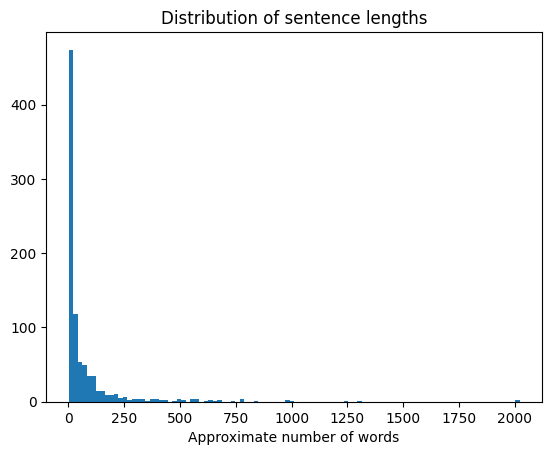

In [ ]:
plt.hist([len(s.split()) for s in sentences], bins=100)
plt.title('Distribution of sentence lengths')
plt.xlabel('Approximate number of words')
plt.show()

The first few sentences detected by NLTK are too short to be considered real sentences. Let's have a look at short sentences wwith at least $20$ characters.

In [ ]:
sorted_sentences = sorted([s for s in sentences if len(s) > 20], key=len)

In [ ]:
for s in sorted_sentences[:5]:
    print(s)

Do you like violence?
Am I comin' or goin'?
Do you like violence?
Am I comin' or goin'?
I don't know help me!


The NLTK sentence tokenizer seems to do a reasonable job. Note that here we se the original case information because it can help the NLTK sentence boundary detection model make better split decisions. Out text corpus is probably too small to train a good sentece aweare language model though, especially with full case information. Using larger corpora such as large collection of [public domain books](http://www.gutenberg.org/) or Wikipedia dumps. The NLTK toolkit also comes from [corpus loading utilities](http://www.nltk.org/book/ch02.html).

The following loads a selection of famous books from the Gutenberg project archive.

In [ ]:
book_selection_text = gutenberg.raw().replace('\n', ' ')

LookupError: 
**********************************************************************
  Resource [93mgutenberg[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('gutenberg')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/gutenberg[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
print(f'Book corpus length: {len(book_selection_text)} characters.')

Book corpus length: 11793318 characters.


## Why build a language model?

Building a language model is not very useful by itself. However language models have recently been shown to be useful for transfer learning to build contextualized word embeddings as a better alternative to word2vec or GloVe.

Using language-model based word representations makes it possible to reach the state-of-the-art at many natural language understanding problems.

The workflow is the following:
* train a (bi-directional) deep language model on a very large, unlabeled corpus (e.g. 1 billion words or more);
* plug the resulting language model as the input layer (and sometimes also the output layer) of a task specific architecture,
    for instance: text classification, semantic role labeling for knowledge extraction, logical entailment, question answering and reading comprehension;
* train the task specific parameters of the new architecture on the smaller task-labeled corpus;
* optionally, fine-tune the full architecture on the task-labeled corpus if it's big enough not to overfit.

More information on this approach:
* Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding." [link](https://arxiv.org/pdf/1810.04805.pdf)
* Deep contextualized word representations, [link](https://arxiv.org/abs/1802.05365)
* Pytorch implementation of ELMo as part of the AllenNLP project: [link](https://github.com/allenai/allennlp)
* Fine-tuned Language Models for Text Classification: [link](https://arxiv.org/abs/1801.06146) (FitLaM)